Loading the data...

In [1]:
from scipy.io import loadmat
import numpy as np

mult_dic = loadmat('../data/Pt110-multislice-v0.mat')
conv = np.load('../data/Pt110-convolution-v0.npy')
mult = mult_dic['ImgG']

# Data wrangling

I extracted the following features for the model:
 - neighbors$^*$: 
              [0, 1, 2,
               3, 4, 5,
               6, 7, 8]
 - gradient using Sobel operator. Convolution with: 
               [-1, 0, 1,           [-1,-2,-1,
                -2, 0, 2,    and      0, 0, 0,
                -1, 0, 1]             1, 2, 1]

I also timed these calculations and rearranged all the features as column vectors in the design matrix $X$.


$^*$ I removed the border pixels because they don't have a full set of neighbors.


#### Extract 8-neighbors

In [2]:
mult = mult[1:-1, 1:-1, ...]

In [3]:
import time
t0 = time.time()
for i in range(100):
    neighbors = np.stack([conv[:-2,:-2,:],
                       conv[:-2,1:-1,:],
                       conv[:-2,2:,:],
                       conv[1:-1,:-2,:],
                       conv[1:-1,1:-1,:],
                       conv[1:-1,2:,:],
                       conv[2:,:-2,:],
                       conv[2:,1:-1,:],
                       conv[2:,2:,:]], axis=3)
t1 = time.time()
total = t1-t0
print('Time to get neighbors = ' + str(total))

Time to get neighbors = 0.14848756790161133


#### Gradient calculation

In [4]:
import cv2

t0 = time.time()
gradx = cv2.Sobel(conv, cv2.CV_64F, 1, 0, ksize=3)
gradx = gradx[1:-1, 1:-1, ...]
grady = cv2.Sobel(conv, cv2.CV_64F, 0, 1, ksize=3)
grady = grady[1:-1, 1:-1, ...]
gradmag = (gradx**2 + grady**2)**0.5
t1 = time.time()
total = t1-t0
print('Time to compute gradients = ' + str(total))


Time to compute gradients = 0.0013663768768310547


In [5]:
print('gradx.shape' + str(gradx.shape))
print('neighbors.shape' + str(neighbors.shape))
print('mult.shape' + str(mult.shape))


gradx.shape(48, 34, 20)
neighbors.shape(48, 34, 20, 9)
mult.shape(48, 34, 20)


#### Final feature matrix $X$

In [6]:
# reduce each image to vector
conv9 = neighbors.reshape(-1,9) # 9 vectors for each pixel
gradx = gradx.reshape(-1,1)
grady = grady.reshape(-1,1)
gradmag = gradmag.reshape(-1,1)
mult = mult.reshape(-1,1)
bias = np.ones(mult.shape) # vector for intercept

import pandas as pd
X = pd.DataFrame(data=np.column_stack((bias, conv9, gradx, grady, gradmag, mult)),
            columns=['bias','p0','p1','p2','p3','p4','p5','p6','p7','p8','gx','gy','gm','mult'])

\pagebreak

# Linear Models with Cross Validation

statsmodels package has a convenient way (R's way) of specifying the formula. I used this package to specify the formulas up front, and the following model fitting and evaulation were automated. I fit linear and quadratic models$^*$ as well as models with log-transformations.

**I ran cross-validation 100 times and averaged out the results later**. In each iteration I split the data into training (20%) and testing (80%) sets. I saved the MSE, R squared, and compute time into the dictionary `results` by appending the tuple to a list.

$^*$ The really long model with np.power(...)s is a quadratic model without interaction. The model following that has all the interaction terms. The **Results** section compares the difference in performance and compute time.

In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


formulas = ['mult ~ bias + p4',
            'mult ~ bias + p4 + p4 ** 2',
            'mult ~ bias + p0 + p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8',
            'mult ~ bias + p0 + p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8 + np.power(p0,2) + np.power(p1,2) + np.power(p2,2) + np.power(p3,2) + np.power(p4,2) + np.power(p5,2) + np.power(p6,2) + np.power(p7,2) + np.power(p8,2)',
            'mult ~ bias + (p0 + p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8)**2',
            'mult ~ bias + (p0 + p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8)**2 + gx + gy + gm',
            'mult ~ bias + p4 + gx + gy + gm',
            'mult ~ bias + p4 + (gx + gy + gm)**2',
            'mult ~ bias + np.log(p4)',
            'np.log(mult) ~ bias + np.log(p4)',
            'mult ~ bias + (np.log(p0) + np.log(p1) + np.log(p2) + np.log(p3) + np.log(p4) + np.log(p5) + np.log(p6) + np.log(p7) + np.log(p8))**2',
            'np.log(mult) ~ bias + (p0 + p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8)**2',
            'np.log(mult) ~ bias + (np.log(p0) + np.log(p1) + np.log(p2) + np.log(p3) + np.log(p4) + np.log(p5) + np.log(p6) + np.log(p7) + np.log(p8))**2'
            ]

seeds = range(100)            

results = {}
for seed in seeds:
    trainX, testX, trainY, testY = train_test_split(X, X['mult'], test_size=0.80)
    
    for f in formulas:
        t0 = time.time()
        mod = smf.ols(formula=f, data=trainX).fit()
        t1 = time.time()
        mse = round(mod.mse_resid,5)
        rsq = round(mod.rsquared, 3)
        t = t1-t0
        predicted = mod.predict(exog=testX)
        if results.get(f) is None:
            results[f] = [(mse, rsq, t)]
        else:
            results[f].append((mse, rsq, t))


\pagebreak

# Result

Here are the results and the parity plots. **Note that when the response variable is transformed, we can't compare the models directly using MSE, $R^2$, AIC, BIC, etc.** Based on the parity plots, **neither gradients nor log-transformations were helpful.**

**The best model was the quadratic model including all the interactions.** It only required 5% extra time compared to the model without interaction, but acheived slightly better average cross-validation MSE and $R^2$ values. **Since these models are nested, I could actually compare the two models using ANOVA.**

In [8]:
# color indicator variable
cols = np.ones((48, 34, 1))
cols = np.stack([i*np.ones((48, 34)) for i in np.arange(1,21)], 2)   
cols = cols.reshape(-1, 1)

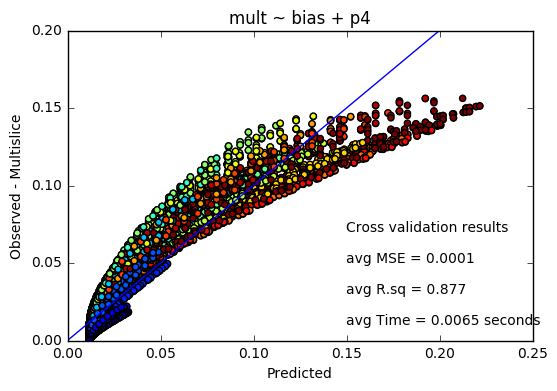

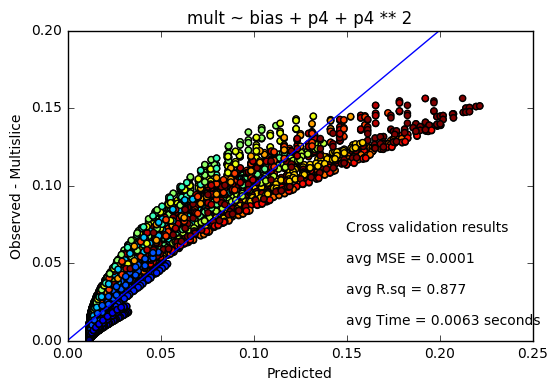

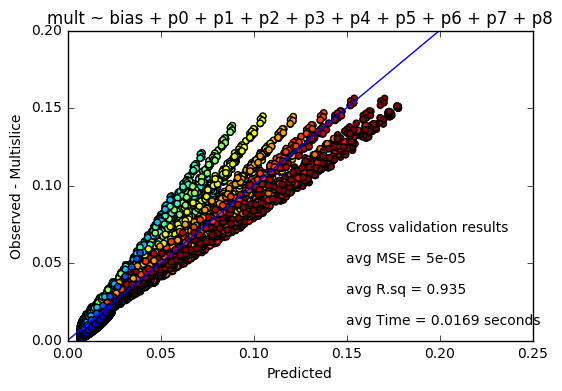

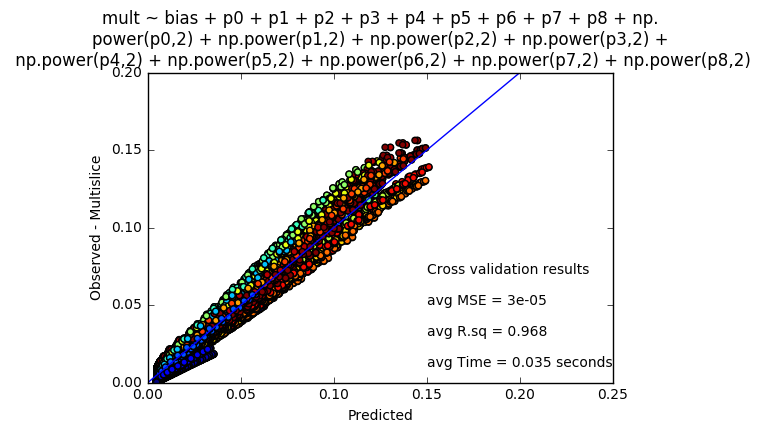

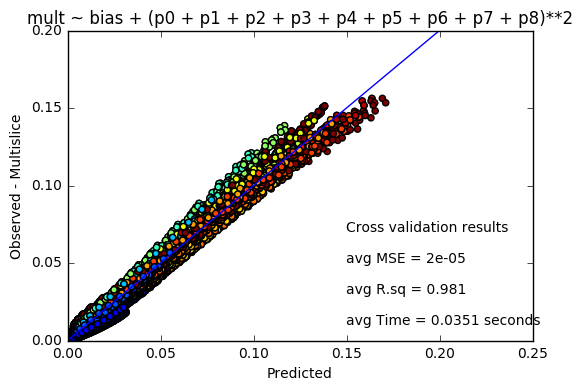

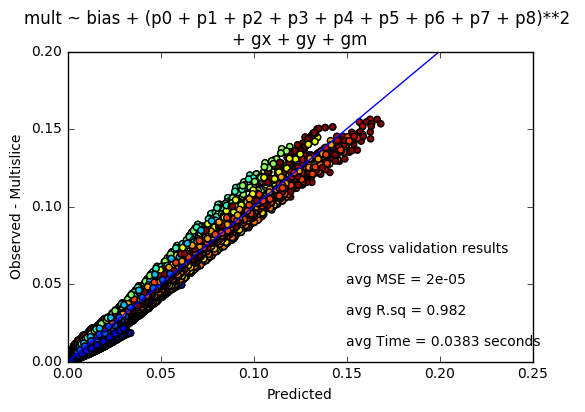

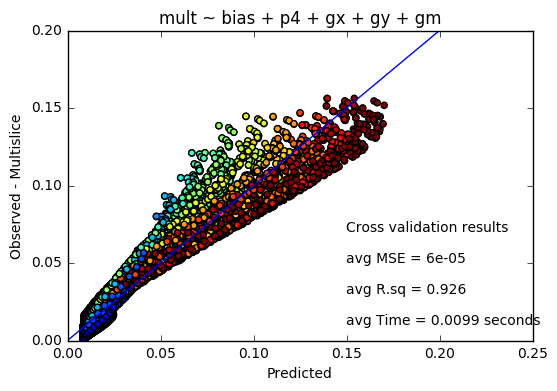

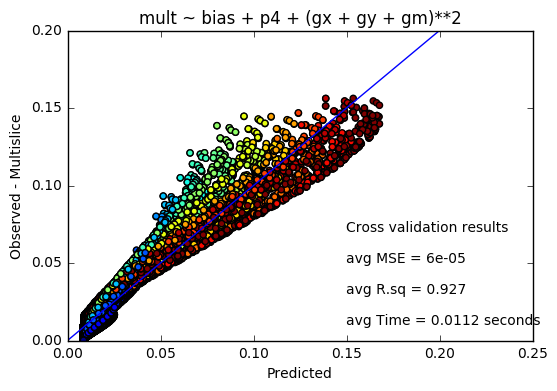

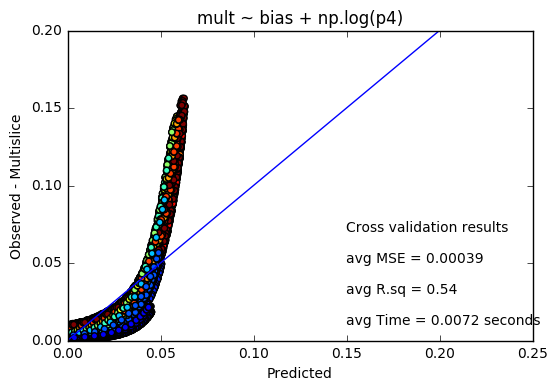

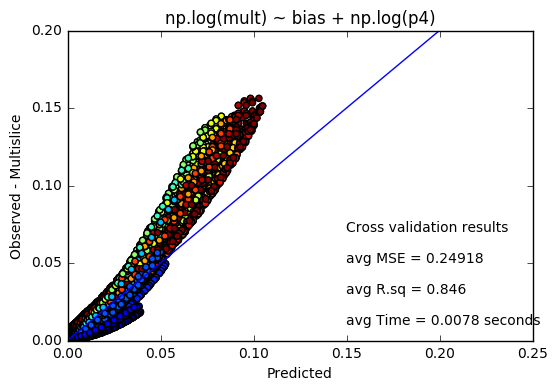

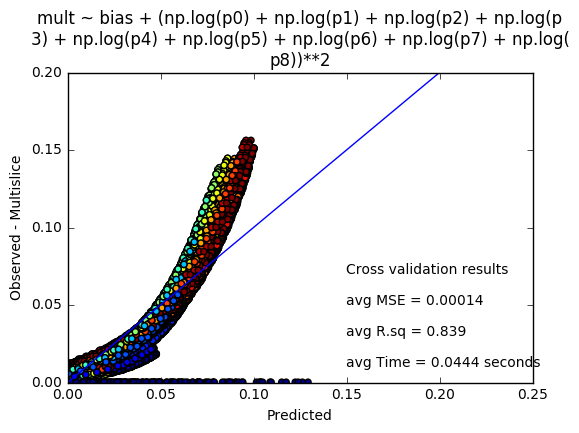

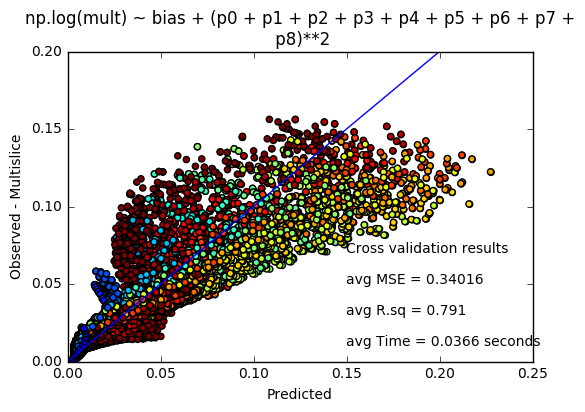

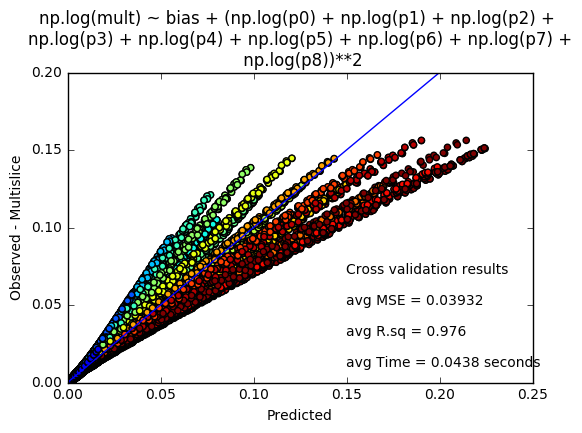

In [9]:
# plot the model and cross-validation results
for f in formulas:
    if f[0:6] == "np.log":
        logScale = True
    else:
        logScale = False

    # average the cross validation results
    mseCV = sum(v[0] for v in results[f])/float(len(results[f]))
    rsqCV = sum(v[1] for v in results[f])/float(len(results[f]))
    timeCV = sum(v[2] for v in results[f])/float(len(results[f]))
    
    # refit the model on the training set
    mod = smf.ols(formula=f, data=X).fit()
    
    # create plots
    plt.figure()
    if logScale:
        plt.scatter(np.exp(mod.predict()), X['mult'], c=cols)
    else:
        plt.scatter(mod.predict(), X['mult'], c=cols)
    plt.plot([0,1,2,3])
    plt.text(0.15, 0.07, 'Cross validation results')
    plt.text(0.15, 0.05, 'avg MSE = ' + str(round(mseCV,5)))
    plt.text(0.15, 0.03, 'avg R.sq = ' + str(round(rsqCV, 3)))
    plt.text(0.15, 0.01, 'avg Time = ' + str(round(timeCV, 4)) + ' seconds')
    plt.title(f if len(f) < 62 else (f[:62] + '\n' + (f[62:] if len(f) < 126 else f[62:126] + '\n' + f[126:])))
    plt.xlabel('Predicted')
    plt.ylabel('Observed - Multislice')
    plt.xlim(0, 0.25)
    plt.ylim(0, 0.2)

    plt.show()

\pagebreak

# Final model - Quadratic with all Interactions

Here I redisplay the results for the best model. I also display its predicted plot against the original images.

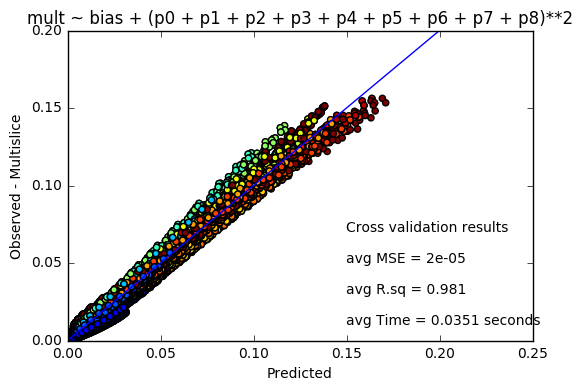

In [12]:
f = 'mult ~ bias + (p0 + p1 + p2 + p3 + p4 + p5 + p6 + p7 + p8)**2'

mseCV = sum(v[0] for v in results[f])/float(len(results[f]))
rsqCV = sum(v[1] for v in results[f])/float(len(results[f]))
timeCV = sum(v[2] for v in results[f])/float(len(results[f]))

mod = smf.ols(formula=f, data=X).fit()
prediction = mod.predict()
plt.figure()
plt.scatter(prediction, X['mult'], c=cols)
plt.plot([0,1,2,3])
plt.text(0.15, 0.07, 'Cross validation results')
plt.text(0.15, 0.05, 'avg MSE = ' + str(round(mseCV,5)))
plt.text(0.15, 0.03, 'avg R.sq = ' + str(round(rsqCV, 3)))
plt.text(0.15, 0.01, 'avg Time = ' + str(round(timeCV, 4)) + ' seconds')
plt.title(f if len(f) < 62 else (f[:62] + '\n' + (f[62:] if len(f) < 126 else f[62:126] + '\n' + f[126:])))
plt.xlabel('Predicted')
plt.ylabel('Observed - Multislice')
plt.xlim(0, 0.25)
plt.ylim(0, 0.2)

plt.show()

#### Model prediction vs. Observed

The images are no longer $50 \times 36 \times 20$ from truncating the boundaries for neighbor calculation. The images are also normalized by subtracting by the mean and dividing by the standard deviation. 

On the difference image, the darker pixels indicate similarity and the brighter pixels indicate difference. **The model seems to predict well on either the center atom or the corner atoms, but not both.** **Does it make sense to crop the images to contain only the center atom?**

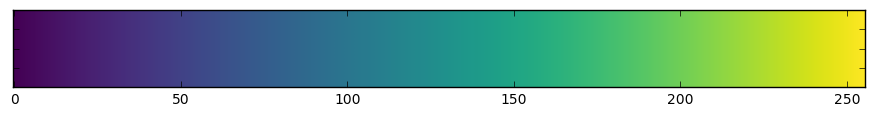

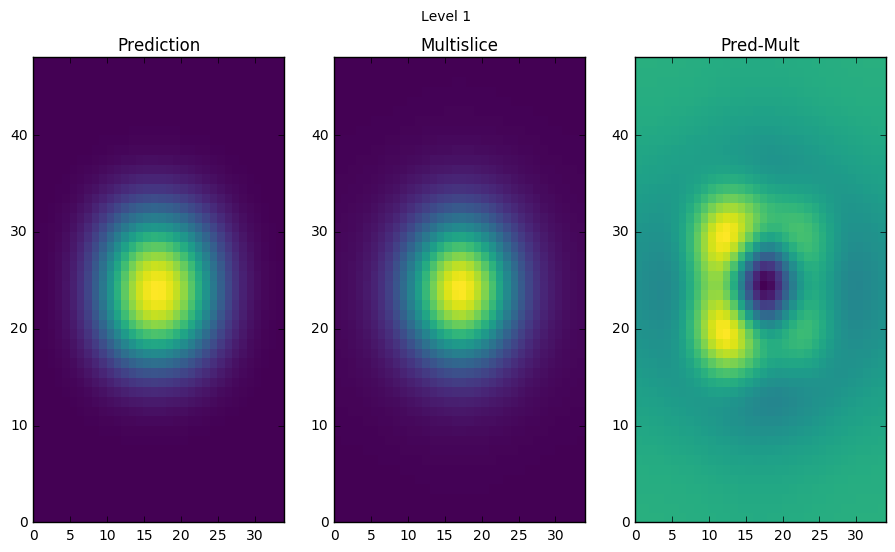

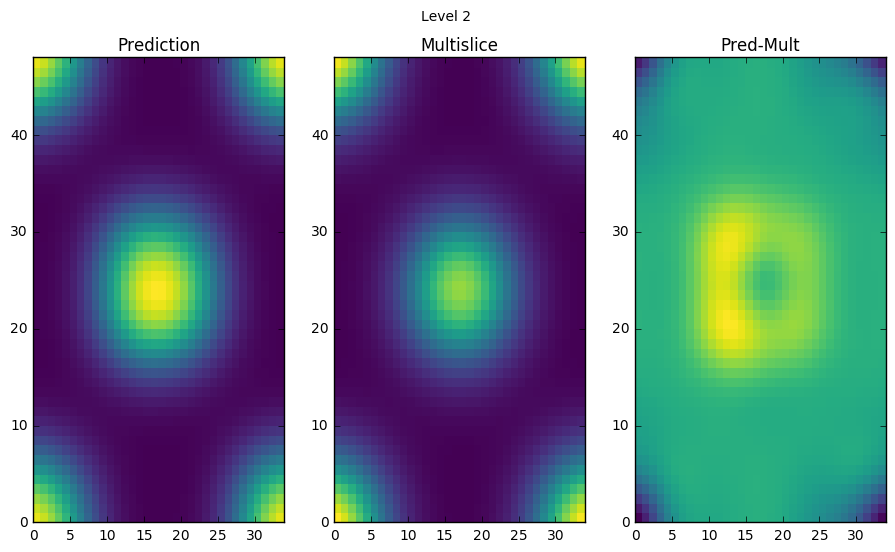

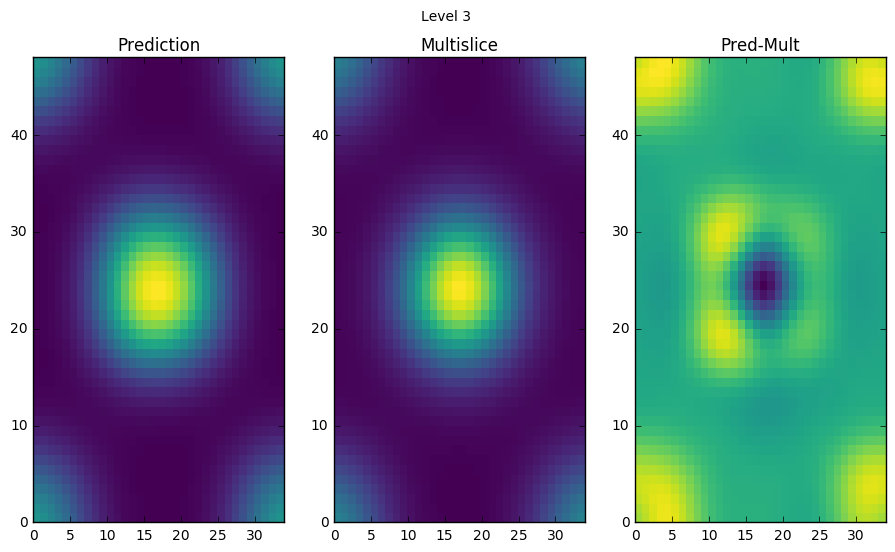

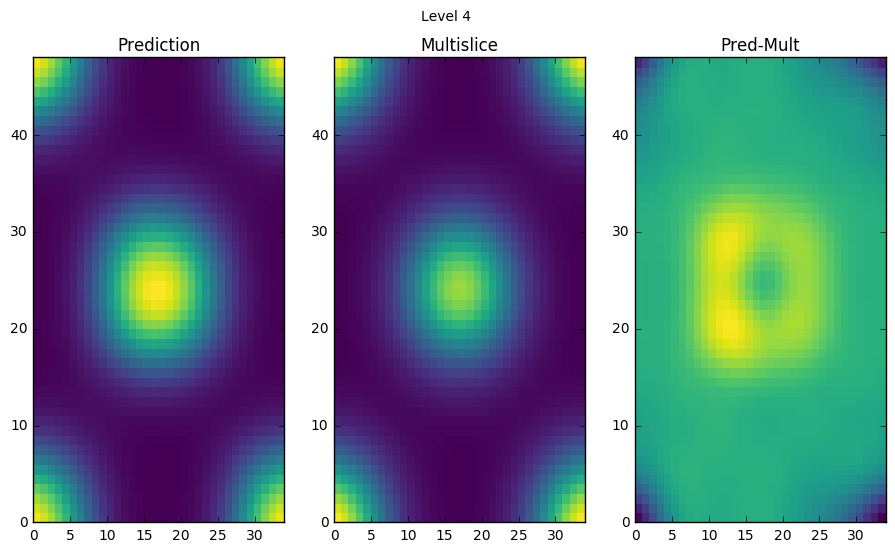

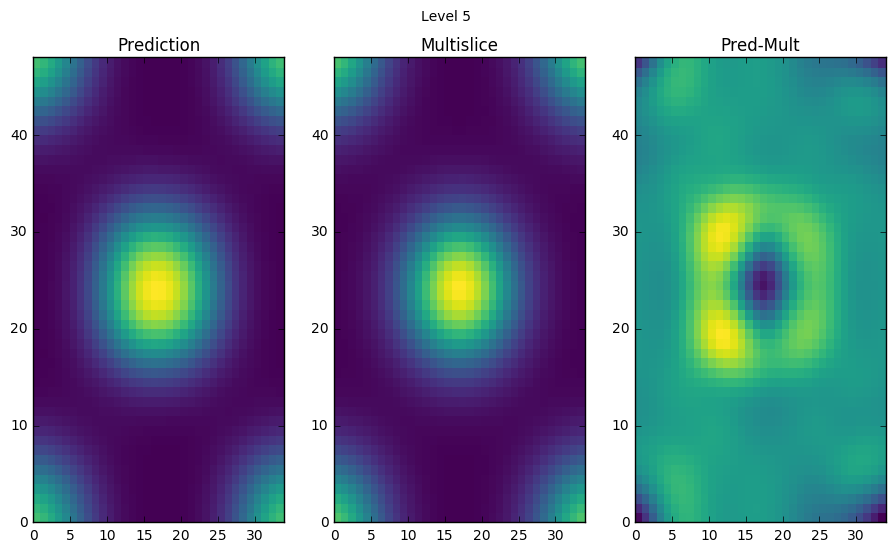

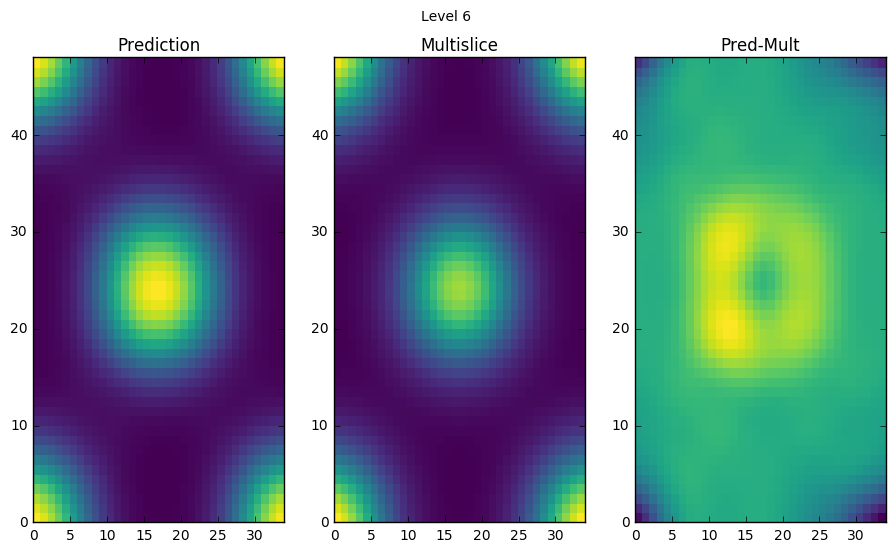

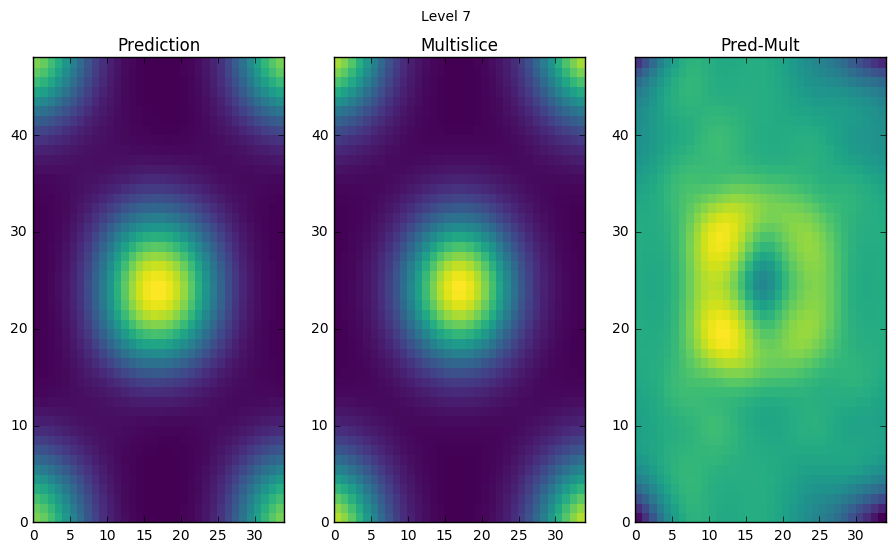

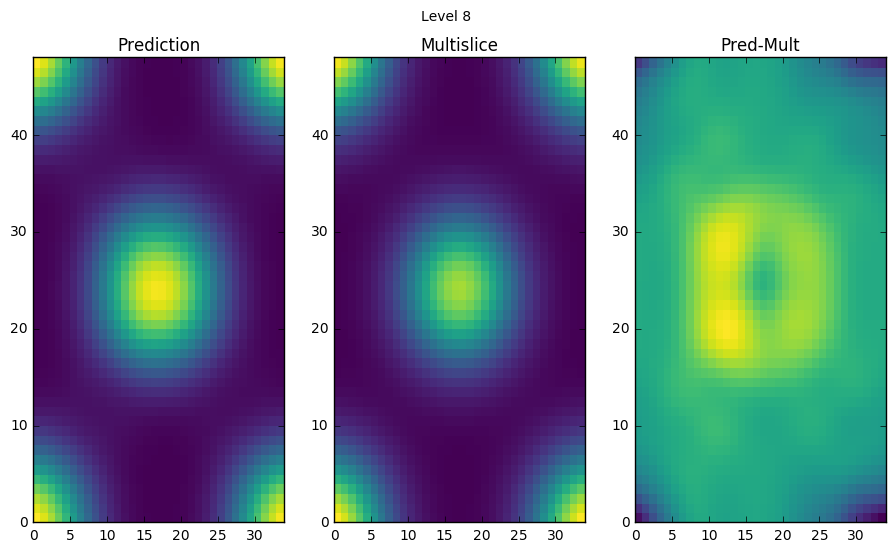

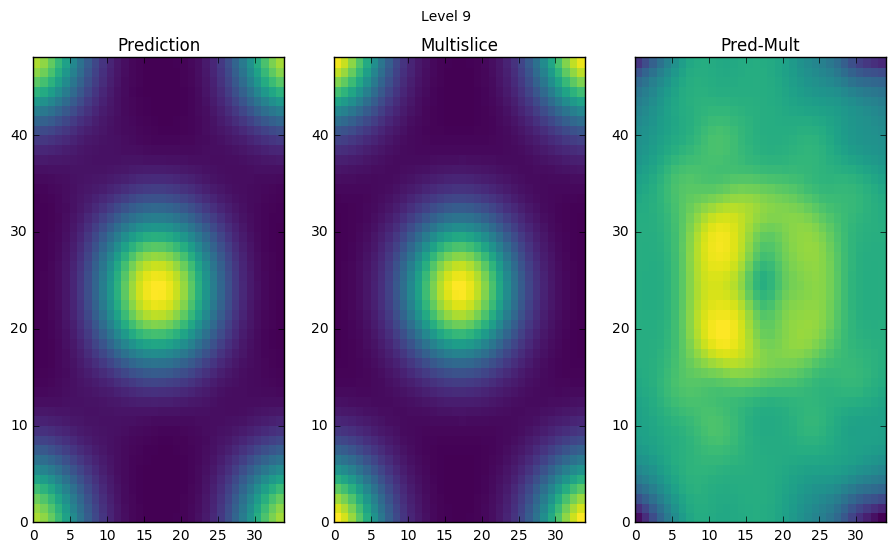

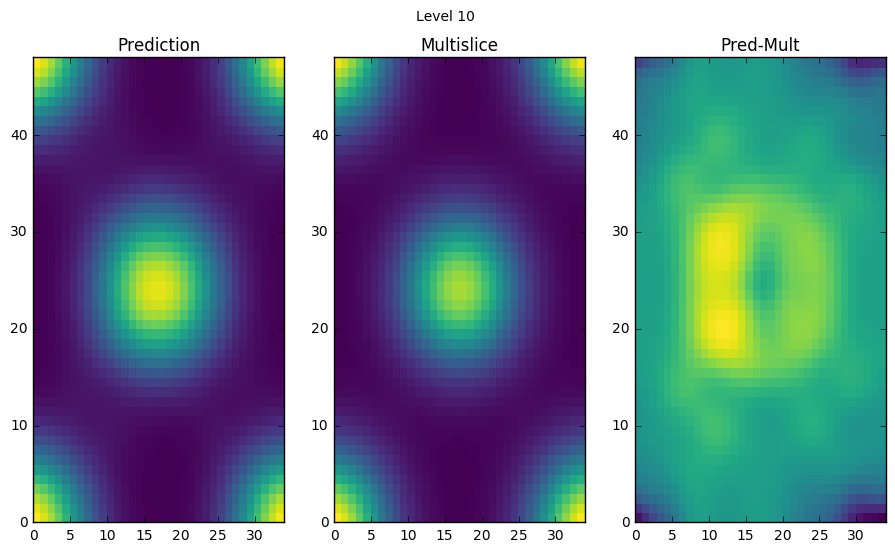

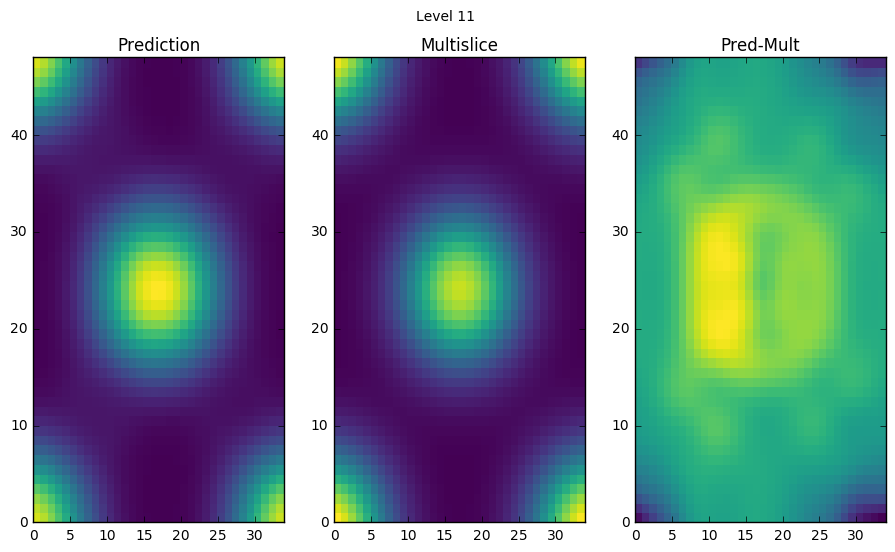

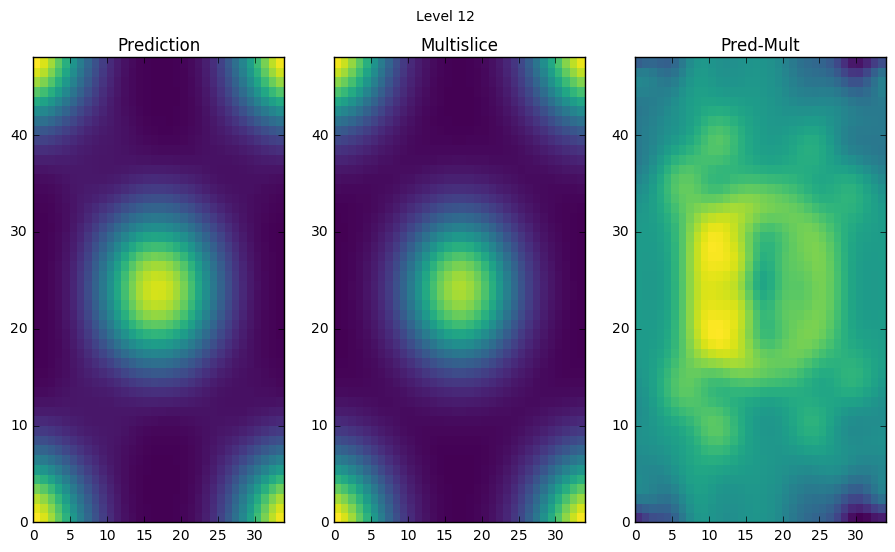

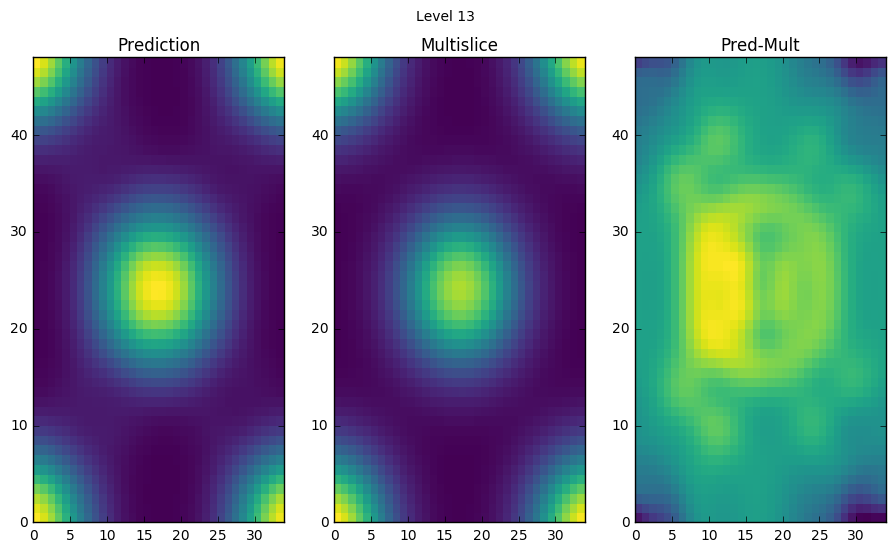

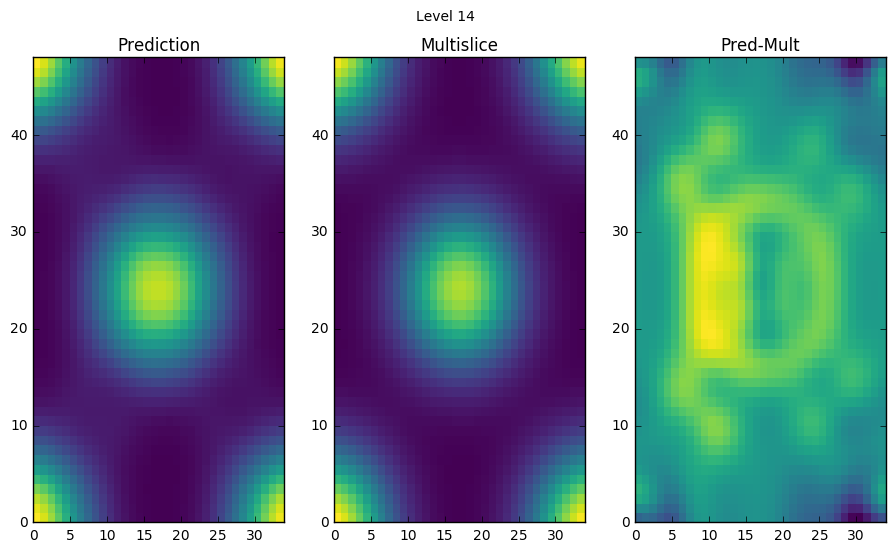

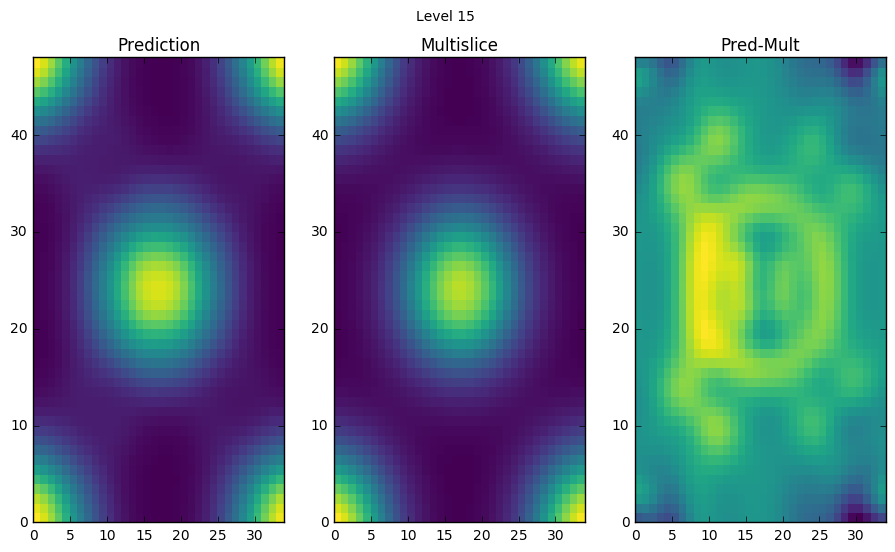

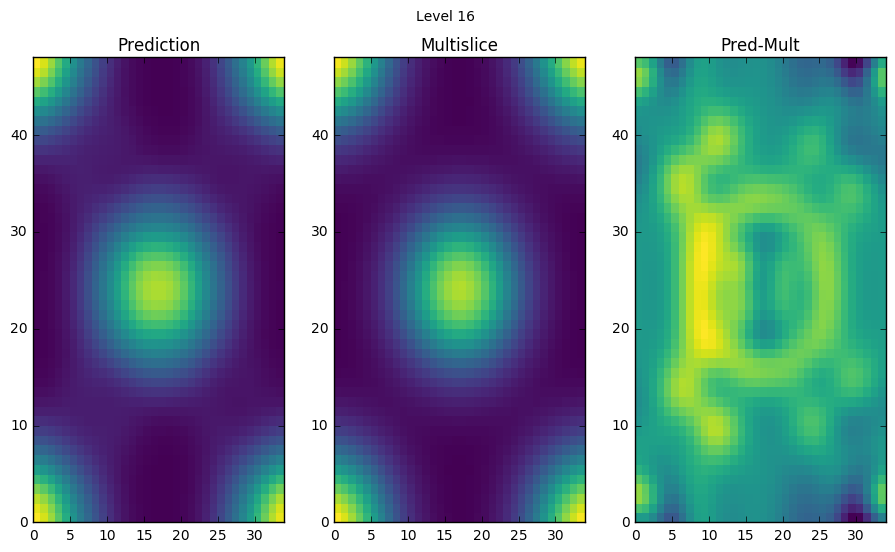

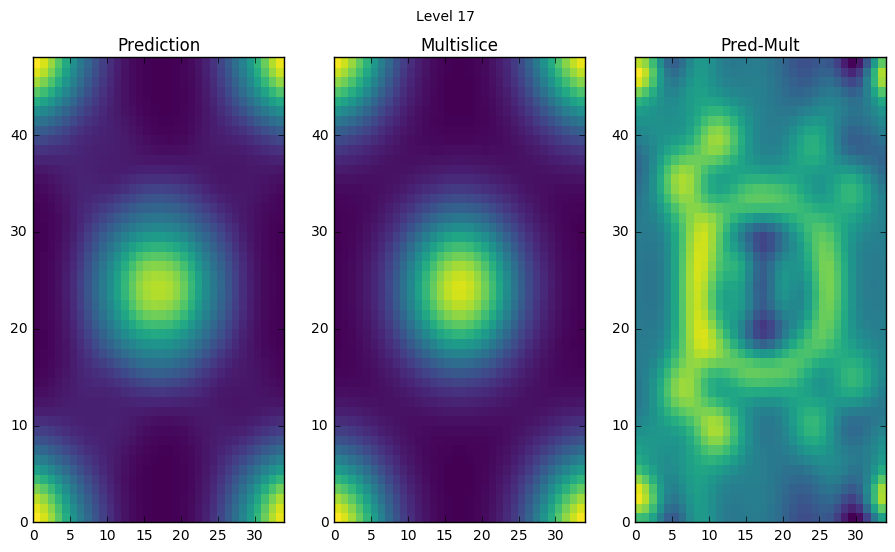

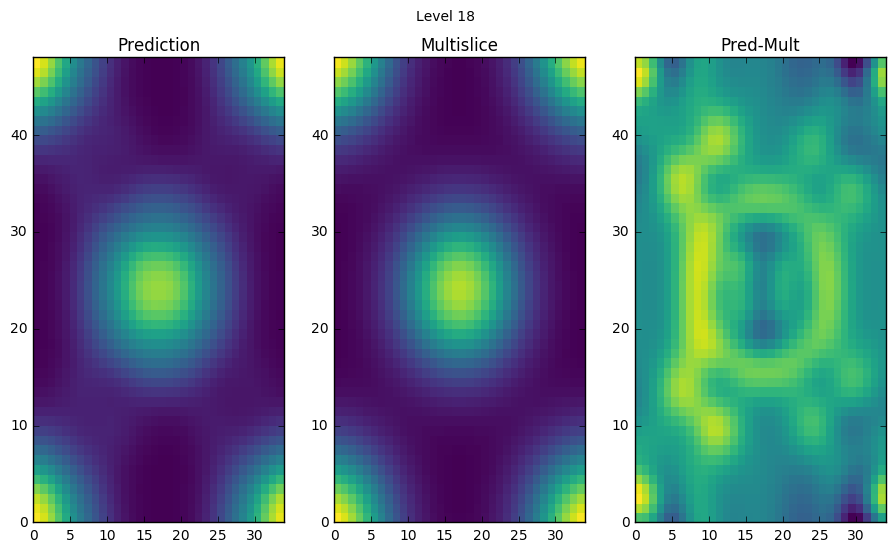

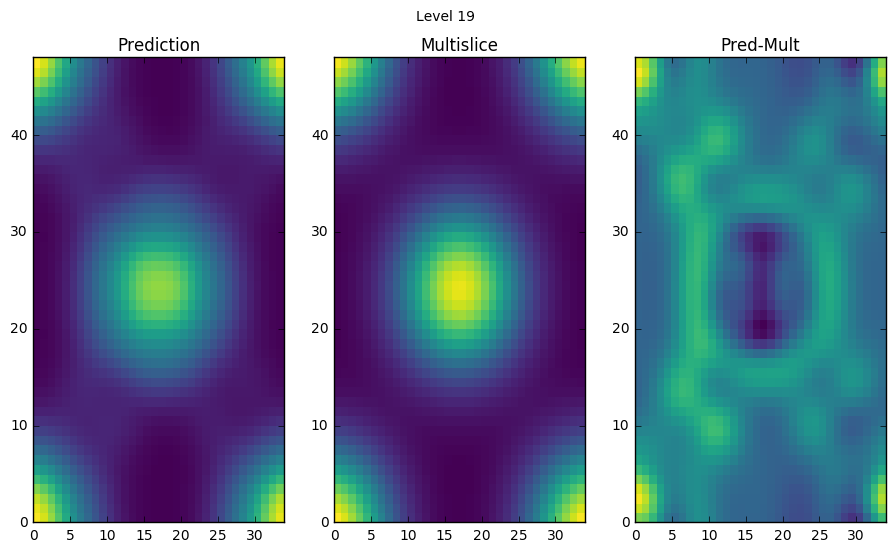

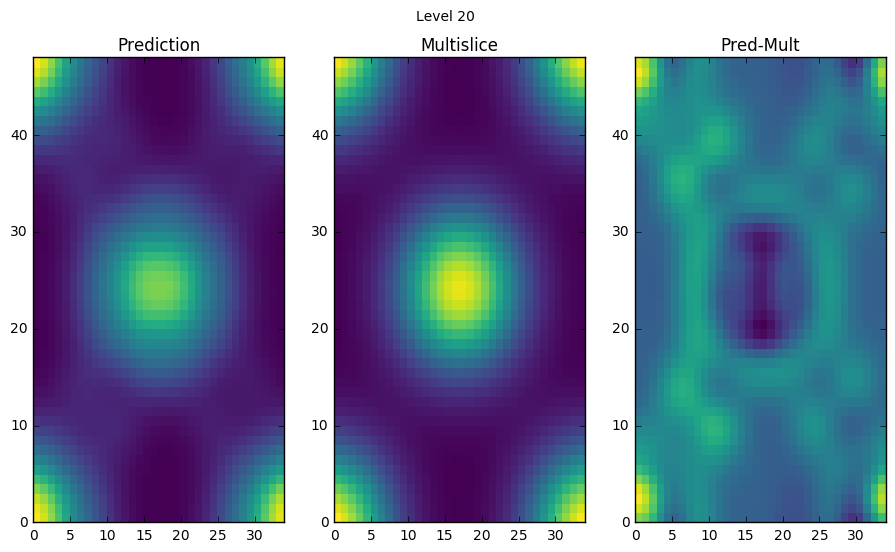

In [11]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(11,1))
ax = plt.subplot(111)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=cm.viridis)
plt.setp(ax.get_yticklabels(), visible=False)
plt.show()

mult.resize(48, 34, 20)
prediction.resize(48, 34, 20)
for i in np.arange(mult.shape[2]):
    fig = plt.figure(i+1, figsize=(11, 6), dpi=400)
    fig.suptitle('Level ' + str(i+1))
    ax1 = fig.add_subplot(131)
    
    # Normalize Images
    pred_norm = (prediction[:,:,i] - prediction[:,:,i].mean())/prediction[:,:,i].std()
    mult_norm = (mult[:,:,i] - mult[:,:,i].mean())/mult[:,:,i].std()

    # Prediction
    ax1.pcolormesh(pred_norm, cmap=cm.viridis)
    ax1.set_xlim(0, prediction.shape[1])
    ax1.set_ylim(0, prediction.shape[0])
    ax1.set_title('Prediction')

    # Multislice
    ax2 = fig.add_subplot(132)
    ax2.pcolormesh(mult_norm, cmap=cm.viridis)
    ax2.set_xlim(0, mult.shape[1])
    ax2.set_ylim(0, mult.shape[0])
    ax2.set_title('Multislice')

    # Difference
    ax3 = fig.add_subplot(133)
    ax3.pcolormesh(pred_norm - mult_norm, cmap=cm.viridis)
    ax3.set_xlim(0, mult.shape[1])
    ax3.set_ylim(0, mult.shape[0])
    ax3.set_title('Pred-Mult')
    plt.show()
    